Part 1. Import the necessary libraries and define VAE model and functions

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split  
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io
import pandas as pd
import netCDF4 as nc
import hypercoast
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
from scipy.interpolate import griddata
from datetime import datetime
from torch.distributions.normal import Normal
from torch.utils.data import DataLoader, TensorDataset, Subset
from tqdm import tqdm

class VAE(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        # encoder
        self.encoder_layer = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2)
        )
        
        self.fc1 = nn.Linear(64, 32) 
        self.fc2 = nn.Linear(64, 32)  

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, output_dim),
            nn.Softplus()
        )

    def encode(self, x):
        x = self.encoder_layer(x)
        mu = self.fc1(x)
        log_var = self.fc2(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, log_var
    
def loss_function(recon_x, x, mu, log_var):
    L1 = F.l1_loss(recon_x, x, reduction='mean')
    BCE = F.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return L1

def load_real_data(excel_path, selected_bands, split_ratio=0.7):

    rounded_bands = [int(round(b)) for b in selected_bands]
    band_cols = [f'Rrs_{b}' for b in rounded_bands]

    df_rrs = pd.read_excel(excel_path, sheet_name='Rrs')
    df_param = pd.read_excel(excel_path, sheet_name='parameter')

    df_rrs_selected = df_rrs[['GLORIA_ID'] + band_cols]
    df_param_selected = df_param[['GLORIA_ID', 'chl-a']]
    df_merged = pd.merge(df_rrs_selected, df_param_selected, on='GLORIA_ID', how='inner')

    mask_rrs_valid = df_merged[band_cols].notna().all(axis=1)
    mask_tss_valid = df_merged['chl-a'].notna()
    df_filtered = df_merged[mask_rrs_valid & mask_tss_valid].reset_index(drop=True)

    lower = df_filtered['chl-a'].quantile(0)
    top = df_filtered['chl-a'].quantile(1)
    df_filtered = df_filtered[(df_filtered['chl-a'] >= lower) & (df_filtered['chl-a'] <= top)].reset_index(drop=True)
    all_sample_ids = df_filtered['GLORIA_ID'].astype(str).tolist()

    Rrs_array = df_filtered[band_cols].values
    Chl_array = df_filtered[['chl-a']].values

    scalers_Rrs = [MinMaxScaler(feature_range=(1, 10)) for _ in range(Rrs_array.shape[0])]
    Rrs_normalized = np.array([scalers_Rrs[i].fit_transform(row.reshape(-1, 1)).flatten() for i, row in enumerate(Rrs_array)])
    Chl_normalized = np.log10(Chl_array+1)

    Rrs_tensor = torch.tensor(Rrs_normalized, dtype=torch.float32)
    Chl_tensor = torch.tensor(Chl_normalized, dtype=torch.float32)
    dataset = TensorDataset(Rrs_tensor, Chl_tensor)

    num_samples = len(dataset)
    indices = np.arange(num_samples)
    np.random.seed(42)
    np.random.shuffle(indices)

    train_size = int(split_ratio * num_samples)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)

    train_ids = [all_sample_ids[i] for i in train_indices]
    test_ids = [all_sample_ids[i] for i in test_indices]

    train_dl = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=0)
    test_dl = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=0)

    input_dim = Rrs_tensor.shape[1]
    output_dim = Chl_tensor.shape[1]

    return train_dl, test_dl, input_dim, output_dim,train_ids, test_ids

def load_real_test(excel_path, selected_bands, max_allowed_diff=1.0):

    df_rrs = pd.read_excel(excel_path, sheet_name='Rrs')
    df_param = pd.read_excel(excel_path, sheet_name='parameter')

    sample_ids = df_rrs['Site Label'].astype(str).tolist()
    sample_dates = df_rrs['Date'].astype(str).tolist()

    rrs_wavelengths = []
    rrs_cols = []
    for col in df_rrs.columns:
        try:
            wl = float(col)
            rrs_wavelengths.append(wl)
            rrs_cols.append(col)
        except:
            continue

    band_cols = []
    matched_bands = []
    for target_band in selected_bands:
        diffs = [abs(wl - target_band) for wl in rrs_wavelengths]
        min_diff = min(diffs)
        best_idx = diffs.index(min_diff)
        band_cols.append(rrs_cols[best_idx])
        matched_bands.append(rrs_wavelengths[best_idx])
    Rrs_array = df_rrs[band_cols].values
    Chl_array = df_param[['Chl-a']].values

    scalers_Rrs = [MinMaxScaler(feature_range=(1, 10)) for _ in range(Rrs_array.shape[0])]
    Rrs_normalized = np.array([scalers_Rrs[i].fit_transform(row.reshape(-1, 1)).flatten() for i, row in enumerate(Rrs_array)])
    Chl_normalized = np.log10(Chl_array+1)
    Rrs_tensor = torch.tensor(Rrs_normalized, dtype=torch.float32)
    Chl_tensor = torch.tensor(Chl_normalized, dtype=torch.float32)
    dataset = TensorDataset(Rrs_tensor, Chl_tensor)

    dataset = TensorDataset(Rrs_tensor, Chl_tensor)
    test_dl = DataLoader(dataset, batch_size=len(dataset), shuffle=False, num_workers=0)

    input_dim = Rrs_tensor.shape[1]
    output_dim = Chl_tensor.shape[1]

    return test_dl, input_dim, output_dim, sample_ids, sample_dates

def calculate_metrics(predictions, actuals, threshold=100):
    """
    Calculate epsilon, beta and additional metrics (RMSE, RMSLE, MAPE, Bias, MAE).
    
    :param predictions: array-like, predicted values
    :param actuals: array-like, actual values
    :param threshold: float, relative error threshold
    :return: epsilon, beta, rmse, rmsle, mape, bias, mae
    """
    # Apply the threshold to filter out predictions with large relative error
    #mask = np.abs(predictions - actuals) / np.abs(actuals+1e-10) < threshold
    #filtered_predictions = predictions[mask]
    #filtered_actuals = actuals[mask]
    #predictions = np.where(predictions <= 1e-10, 1e-10, predictions)
    #actuals = np.where(actuals <= 1e-10, 1e-10, actuals)
    filtered_predictions = predictions
    filtered_actuals = actuals
    
    # Calculate epsilon and beta
    log_ratios = np.log10(filtered_predictions / filtered_actuals)
    Y = np.median(np.abs(log_ratios))
    Z = np.median(log_ratios)
    epsilon = 100 * (10**Y - 1)
    beta = 50 * np.sign(Z) * (10**np.abs(Z) - 1)
    
    # Calculate additional metrics
    rmse = np.sqrt(np.mean((filtered_predictions - filtered_actuals) ** 2))
    rmsle = np.sqrt(np.mean((np.log10(filtered_predictions + 1) - np.log10(filtered_actuals + 1)) ** 2))
    mape = 50 * np.median(np.abs((filtered_predictions - filtered_actuals) / filtered_actuals))
    bias = 10 ** (np.mean(np.log10(filtered_predictions) - np.log10(filtered_actuals)))
    mae = 10** np.mean(np.abs(np.log10(filtered_predictions) - np.log10(filtered_actuals)))
    
    return epsilon, beta, rmse, rmsle, mape, bias, mae

def plot_results(predictions_rescaled, actuals_rescaled, save_dir, threshold=100, mode='test'):

    actuals = actuals_rescaled.flatten()
    predictions = predictions_rescaled.flatten()

    log_actuals = np.log10(actuals)
    log_predictions = np.log10(predictions)

    #mask = np.abs(predictions - actuals) / np.abs(actuals+1e-10) < threshold
    mask = ((np.abs(log_predictions - log_actuals) < threshold))
    filtered_predictions = predictions[mask]
    filtered_actuals = actuals[mask]

    log_actual = np.log10(np.where(actuals == 0, 1e-10, actuals))
    log_prediction = np.log10(np.where(predictions == 0, 1e-10, predictions))

    filtered_log_actual = np.log10(np.where(filtered_actuals == 0, 1e-10, filtered_actuals))
    filtered_log_prediction = np.log10(np.where(filtered_predictions == 0, 1e-10, filtered_predictions))

    epsilon, beta, rmse, rmsle, mape, bias, mae = calculate_metrics(filtered_predictions, filtered_actuals,threshold)

    valid_mask = np.isfinite(filtered_log_actual) & np.isfinite(filtered_log_prediction)
    slope, intercept = np.polyfit(filtered_log_actual[valid_mask], filtered_log_prediction[valid_mask], 1)
    x = np.array([-2, 4])
    y = slope * x + intercept

    plt.figure(figsize=(6, 6))


    plt.plot(x, y, linestyle='--', color='blue', linewidth=0.8)
    lims = [-2, 4]
    plt.plot(lims, lims, linestyle='-',color='black', linewidth=0.8)

    sns.scatterplot(x=log_actual, y=log_prediction, alpha=0.5)
    
    sns.kdeplot(x=filtered_log_actual, y=filtered_log_prediction, levels=3, color="black", fill=False, linewidths=0.8)

    plt.xlabel('Actual Chl-a Values', fontsize=16, fontname='Ubuntu')
    plt.ylabel('Predicted Chl-a Values', fontsize=16, fontname='Ubuntu')
    plt.xlim(-2, 4)
    plt.ylim(-2, 4)
    plt.grid(True, which="both", ls="--")

    plt.legend(title=(f'MAE = {mae:.2f}, RMSE = {rmse:.2f}, RMSLE = {rmsle:.2f} \n'
                    f'Bias = {bias:.2f}, Slope = {slope:.2f} \n'
                    f'MAPE = {mape:.2f}%, ε = {epsilon:.2f}%, β = {beta:.2f}%'),
            fontsize=16, title_fontsize=12, prop={'family': 'Ubuntu'})

    plt.xticks(fontsize=20, fontname='Ubuntu')
    plt.yticks(fontsize=20, fontname='Ubuntu')

    plt.savefig(os.path.join(save_dir, f'{mode}_plot.pdf'), bbox_inches='tight')
    plt.close()

def save_results_to_excel(ids, actuals, predictions, file_path, dates=None):

    if dates is not None:
        df = pd.DataFrame({
            'ID': ids,
            'Date': dates,
            'Actual': actuals,
            'Predicted': predictions
        })
    else:
        df = pd.DataFrame({
            'ID': ids,
            'Actual': actuals,
            'Predicted': predictions
        })

    df.to_excel(file_path, index=False)


Part 2. In this section, we used the VAE deep learning algorithm to train a MSI-Chla model and evaluated its performance on both the training dataset and the validation dataset.

In [ ]:
def train(model, train_dl, device, epochs=200, optimizer=None, save_dir=None):
    model.train()

    min_total_loss = float('inf')
    best_model_path = os.path.join(save_dir, 'best_model_minloss.pth')

    total_list = []
    l1_list = []

    for epoch in range(epochs):
        total_loss_epoch = 0.0
        l1_epoch = 0.0

        for x, y in train_dl:
            x, y = x.to(device), y.to(device)

            y_pred, mu, log_var = model(x)
            loss = loss_function(y_pred, y, mu, log_var)
            l1 = loss  

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss_epoch += loss.item()
            l1_epoch += l1.item()

        avg_total_loss = total_loss_epoch / len(train_dl)
        avg_l1 = l1_epoch / len(train_dl)

        print(f"[Epoch {epoch+1}] Total: {avg_total_loss:.4f} | L1: {avg_l1:.4f}")

        total_list.append(avg_total_loss)
        l1_list.append(avg_l1)

        if avg_total_loss < min_total_loss:
            min_total_loss = avg_total_loss
            torch.save(model.state_dict(), best_model_path)

    return { "total_loss": total_list, "l1_loss": l1_list, "best_loss": min_total_loss}

def evaluate(model, test_dl, device):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to(device), y.to(device)
            y_pred, _, _ = model(x)
            predictions.append(y_pred.cpu().numpy())
            actuals.append(y.cpu().numpy())

    predictions = np.vstack(predictions).flatten()
    actuals = np.vstack(actuals).flatten()
    predictions_inverse = np.power(10, predictions) - 1
    actuals_inverse = np.power(10, actuals) - 1
    return predictions_inverse, actuals_inverse

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")


    selected_bands = [443, 492, 560, 665, 704, 740]

    train_real_dl, test_real_dl, input_dim, output_dim, train_ids, test_ids = load_real_data('/home/data/20250727/data/Gloria_updated_07242025.xlsx', selected_bands)
    test_dl1, _, _, test_ids1, test_dates = load_real_test('/home/data/20250727/data/GreatLake_all_data.xlsx', selected_bands)
    test_dl2, _, _, test_ids2, test_dates2 = load_real_test('/home/data/20250727/data/GOA_insitu_data_07242025updated.xlsx', selected_bands)

    save_dir = "/home/data/20250727/vae/MSI01"
    os.makedirs(save_dir, exist_ok=True)

    model = VAE(input_dim, output_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

    train_log = train(model=model,train_dl=train_real_dl,device=device,epochs=400,optimizer=optimizer,save_dir=save_dir)
    best_train_loss = train_log["best_loss"]

    predictions, actuals = evaluate(model, test_real_dl, device)
    epsilon, beta, rmse, rmsle, mape, bias, mae = calculate_metrics(predictions, actuals)
    test_loss = rmse

    predictions_GL, actuals_GL = evaluate(model, test_dl1, device)
    epsilon_GL, beta_GL, rmse_GL, rmsle_GL, mape_GL, bias_GL, mae_GL = calculate_metrics(predictions_GL, actuals_GL)
    predictions_Field_work, actuals_Field_work = evaluate(model, test_dl2, device)

    save_results_to_excel(test_ids, actuals, predictions, os.path.join(save_dir, 'test.xlsx'))
    save_results_to_excel(test_ids1, actuals_GL, predictions_GL, os.path.join(save_dir, 'GL.xlsx'), dates=test_dates)
    save_results_to_excel(test_ids2, actuals_Field_work, predictions_Field_work, os.path.join(save_dir, 'GOA.xlsx'), dates=test_dates2)

    train_Rrs, train_Chl = [], []
    for x, y in train_real_dl:
        train_Rrs.append(x.cpu().numpy())
        train_Chl.append(y.cpu().numpy())
    train_data = np.hstack((np.vstack(train_Rrs), np.vstack(train_Chl)))

    test_Rrs, test_Chl = [], []
    for x, y in test_real_dl:
        test_Rrs.append(x.cpu().numpy())
        test_Chl.append(y.cpu().numpy())
    test_data = np.hstack((np.vstack(test_Rrs), np.vstack(test_Chl)))

    np.savetxt(os.path.join(save_dir, 'train_data.csv'), train_data, delimiter=',',
                header=','.join([f'Rrs_{i}' for i in range(input_dim)] + ['Chla']), comments='')
    np.savetxt(os.path.join(save_dir, 'test_data.csv'), test_data, delimiter=',',
                header=','.join([f'Rrs_{i}' for i in range(input_dim)] + ['Chla']), comments='')

    plot_results(predictions, actuals, save_dir, mode='test')
    plot_results(predictions_GL, actuals_GL, save_dir, mode='GL')
    plot_results(predictions_Field_work, actuals_Field_work, save_dir, mode='GOA')

    print(f"Run completed with train loss: {best_train_loss:.4f}, test loss: {test_loss:.4f}")

if __name__ == '__main__':
    main()

Part 3. We need to download the MSI Level-1 data, process it with ACOLITE to generate Level-2 water-leaving reflectance (L2W) products, and then perform model inference to generate chlorophyll-a (Chl-a) concentration maps.

In [ ]:
input_path = '/home/data/Chl-MSI/Harvey/Second/processed data/S2A_MSI_2017_09_01_17_05_34_T15RUN_L2W.nc'
output_path = '/home/data/20250727/vae/MSI/0-100/run_7/S2A_MSI_2017_09_01_17_05_34_T15RUN_L2W.npy'
model_path = '/home/data/20250727/vae/MSI/0-100/run_7/best_model_minloss.pth'

output_dim = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = nc.Dataset(input_path)
latitude = dataset.variables['lat'][:]
longitude = dataset.variables['lon'][:]

all_vars = dataset.variables.keys()
bands_to_extract = [
    f'Rrs_{wavelength}' for wavelength in range(399, 755)
    if f'Rrs_{wavelength}' in all_vars
]
input_dim = len(bands_to_extract)
if input_dim == 0:
    raise ValueError("❌ No valid bands found.")

model = VAE(input_dim, output_dim).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

filtered_Rrs = np.array([dataset.variables[band][:] for band in bands_to_extract])  # shape: (bands, H, W)
filtered_Rrs = np.moveaxis(filtered_Rrs, 0, -1)  # shape: (H, W, bands)

mask = np.all(~np.isnan(filtered_Rrs), axis=2)

def find_closest_band(target, available_bands):
    available_waves = [int(b.split('_')[1]) for b in available_bands]
    closest_wave = min(available_waves, key=lambda w: abs(w - target))
    return f'Rrs_{closest_wave}'

target_443 = 'Rrs_443' if 'Rrs_443' in bands_to_extract else find_closest_band(443, bands_to_extract)
target_560 = 'Rrs_560' if 'Rrs_560' in bands_to_extract else find_closest_band(560, bands_to_extract)

print(f"Using {target_443} and {target_560} for mask check.")

idx_443 = bands_to_extract.index(target_443)
idx_560 = bands_to_extract.index(target_560)
mask &= (filtered_Rrs[:, :, idx_443] <= filtered_Rrs[:, :, idx_560])


valid_test_data = filtered_Rrs[mask]
valid_test_data = np.array([
    MinMaxScaler(feature_range=(1, 10)).fit_transform(row.reshape(-1, 1)).flatten()
    for row in valid_test_data
])

test_tensor = TensorDataset(torch.tensor(valid_test_data).float())
test_loader = DataLoader(test_tensor, batch_size=2048, shuffle=False)

predictions_all = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch[0].to(device)
        predictions, _, _ = model(batch)
        predictions = 10 ** predictions - 1 
        predictions_all.append(predictions.cpu().numpy())

predictions_all = np.vstack(predictions_all)
if predictions_all.shape[-1] == 1:
    predictions_all = predictions_all.squeeze(-1)

outputs = np.full((filtered_Rrs.shape[0], filtered_Rrs.shape[1]), np.nan)
outputs[mask] = predictions_all

lat_flat = latitude.flatten()
lon_flat = longitude.flatten()
output_flat = outputs.flatten()

final_output = np.column_stack((lat_flat, lon_flat, output_flat))
if isinstance(final_output, np.ma.MaskedArray):
    final_output = final_output.filled(np.nan)

os.makedirs(os.path.dirname(output_path), exist_ok=True)
np.save(output_path, final_output)
print(f"✅ Processed and saved to: {output_path}")

Using Rrs_443 and Rrs_560 for mask check.
✅ Processed and saved to: /home/data/20250727/vae/MSI/0-100/run_7/S2A_MSI_2017_09_01_17_05_34_T15RUN_L2W.npy


Part 4. We interpolate the Chl-a results saved in the .npy file generated in Part 3 and overlay them onto the RGB image from the ACOLITE-generated Level-2 Reflectance (L2R) file for visualization of the Chl-a distribution.

Using bands: R=rhos_665, G=rhos_560, B=rhos_492


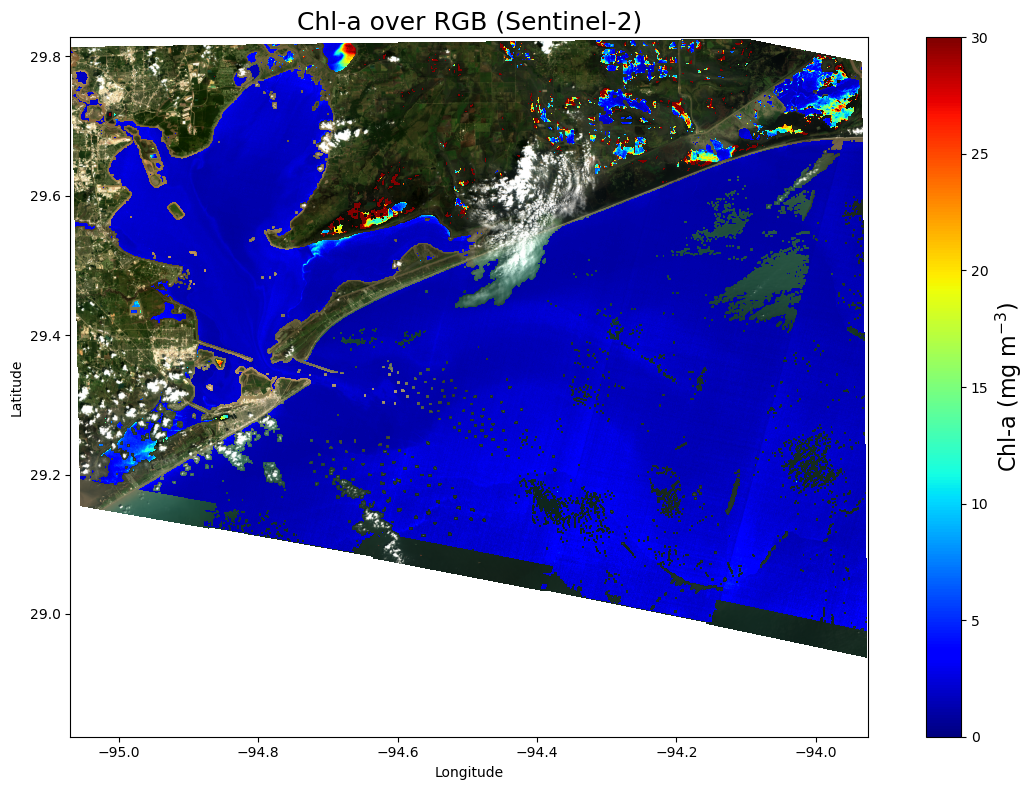

In [4]:
nc_file = '/home/data/Chl-MSI/Harvey/Second/processed data/S2A_MSI_2017_09_01_17_05_34_T15RUN_L2R.nc'
chla_data_file = '/home/data/20250727/vae/MSI/0-100/run_7/S2A_MSI_2017_09_01_17_05_34_T15RUN_L2W.npy'

dataset = nc.Dataset(nc_file)
lat = dataset.variables['lat'][:]
lon = dataset.variables['lon'][:]
height, width = lat.shape

def find_closest_band(target, var_keys):
    available = [v for v in var_keys if v.startswith('rhos_')]
    wavelengths = [int(v.split('_')[1]) for v in available]
    closest_wave = min(wavelengths, key=lambda w: abs(w - target))
    return f"rhos_{closest_wave}"

all_vars = dataset.variables.keys()

R_band = 'rhos_665' if 'rhos_665' in all_vars else find_closest_band(665, all_vars)
G_band = 'rhos_559' if 'rhos_559' in all_vars else find_closest_band(559, all_vars)
B_band = 'rhos_492' if 'rhos_492' in all_vars else find_closest_band(492, all_vars)
print(f"Using bands: R={R_band}, G={G_band}, B={B_band}")

R = dataset.variables[R_band][:]
G = dataset.variables[G_band][:]
B = dataset.variables[B_band][:]

lat_flat = lat.flatten()
lon_flat = lon.flatten()
R_flat = R.flatten()
G_flat = G.flatten()
B_flat = B.flatten()

grid_lat = np.linspace(lat.min(), lat.max(), height)
grid_lon = np.linspace(lon.min(), lon.max(), width)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

R_interp = griddata((lat_flat, lon_flat), R_flat, (grid_lat, grid_lon), method='linear')
G_interp = griddata((lat_flat, lon_flat), G_flat, (grid_lat, grid_lon), method='linear')
B_interp = griddata((lat_flat, lon_flat), B_flat, (grid_lat, grid_lon), method='linear')

rgb_image = np.stack((R_interp, G_interp, B_interp), axis=-1)
rgb_image = rgb_image / np.nanmax(rgb_image)
rgb_image = np.clip(rgb_image * 5.0, 0, 1)  

chla_data = np.load(chla_data_file)
chla_lat = chla_data[:, 0]
chla_lon = chla_data[:, 1]
chla_values = chla_data[:, 2]

chla_interp = griddata((chla_lat, chla_lon), chla_values, (grid_lat, grid_lon), method='nearest')
chla_interp = np.ma.masked_invalid(chla_interp)

rgb_valid = np.sum(rgb_image, axis=-1) > 0
mask = np.zeros_like(chla_interp, dtype=bool)
mask[rgb_valid] = True
chla_interp_masked = np.ma.masked_where(~mask, chla_interp)

extent = [lon.min(), lon.max(), lat.min(), lat.max()]
vmin, vmax = 0, 30

plt.figure(figsize=(12, 8))
plt.imshow(rgb_image, extent=extent, origin='lower')
im = plt.imshow(chla_interp_masked, extent=extent, cmap='jet', alpha=1, origin='lower', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(im)
cbar.set_label('Chl-a (mg m$^{-3}$)', fontsize=16)
plt.title("Chl-a over RGB (Sentinel-2)", fontsize=18)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()
